In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
torch.manual_seed(2019)

In [2]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [4]:
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [5]:
# transform = transforms.Compose([transforms.Resize((28,28)),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,), (0.5,))
#                                ])
# training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [6]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [7]:
#convert from tensor to numpy
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # (1,28,28)
    image = image.transpose(1, 2, 0) # (28,28,1)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denormalize
    image = image.clip(0, 1)
    return image

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

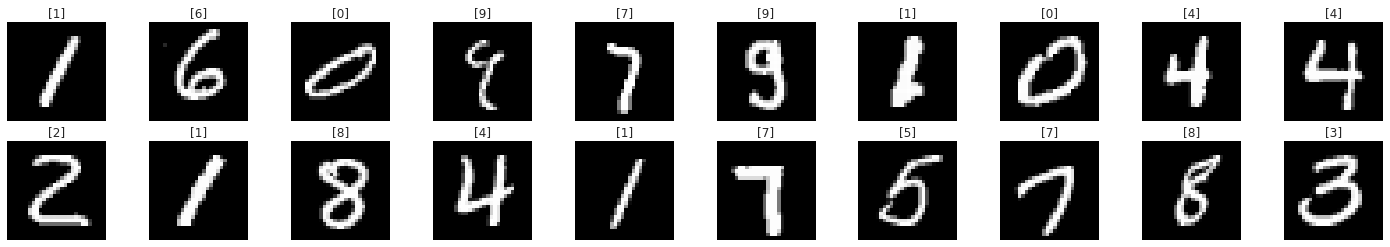

In [9]:
#Plot some images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)#lkernel size = n of the filters
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)#
        self.fc1 = nn.Linear(4*4*50, 500)#depth of 50 and 4x4 image
        self.dropout1 = nn.Dropout(0.5)#drop to prevent overfitting better used on large layers
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)#cut the zise of the picture in half but mantain the information
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)#cut the zise
        x = x.view(-1, 4*4*50) #flatten to the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [18]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss() # used for multiclass classification
optmizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 20
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    #each training batch
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # return proba for each class (score)
        loss = criterion(outputs, labels)
        
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
        #max score output class
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item()
        #number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        
        
    else:
        #execute once loop end
        
        with torch.no_grad(): #set all the grad flags to false to get better perfomance
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs) # return proba for each class (score)
                val_loss = criterion(val_outputs, val_labels)
                
                #max score output class
                _, val_preds = torch.max(val_outputs, 1)

                val_running_loss += val_loss.item()
                #number of correct predictions
                val_running_corrects += torch.sum(val_preds == val_labels.data)


            epoch_loss = running_loss/len(training_loader)#n of batches
            epoch_acc = running_corrects.float()/len(training_loader)
            running_loss_history.append(epoch_loss)
            running_correct_history.append(epoch_acc)
            
            val_epoch_loss = val_running_loss/len(validation_loader)#n of batches
            val_epoch_acc = val_running_corrects.float()/len(validation_loader)
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)
            
            print('training loss: {:.4f} - training acc: {:.4f} | validation loss: {:.4f} - val acc: {:.4f}'.format(
                epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

training loss: 0.5735 - training acc: 85.0033 | validation loss: 0.1723 - val acc: 94.9700
training loss: 0.1428 - training acc: 95.7317 | validation loss: 0.0997 - val acc: 96.8900
training loss: 0.0967 - training acc: 97.0833 | validation loss: 0.0738 - val acc: 97.8400
training loss: 0.0739 - training acc: 97.7750 | validation loss: 0.0603 - val acc: 98.1400
training loss: 0.0624 - training acc: 98.1617 | validation loss: 0.0510 - val acc: 98.3700
training loss: 0.0539 - training acc: 98.3650 | validation loss: 0.0457 - val acc: 98.6100
training loss: 0.0469 - training acc: 98.5967 | validation loss: 0.0391 - val acc: 98.7100
training loss: 0.0422 - training acc: 98.7183 | validation loss: 0.0355 - val acc: 98.8400
training loss: 0.0384 - training acc: 98.8433 | validation loss: 0.0359 - val acc: 98.7800
training loss: 0.0346 - training acc: 98.9217 | validation loss: 0.0320 - val acc: 99.0000
training loss: 0.0308 - training acc: 99.0383 | validation loss: 0.0322 - val acc: 98.9100

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()

# test random images

In [ ]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [ ]:
#Preprocessing
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
#predict
imgs = img.to(device)
imgs = imgs[0].unsquezee(0).unsquezee(0)
output = model(imgs)
_, pred = torch.max(output, 1)
print(output)
print("Prediction: ", pred.item())

In [ ]:
#predict all vals and print 20
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(40):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), 
                                  str(labels[idx].item())), 
                 color=("green" if preds[idx]==labels[idx] else "red"))

## example of too large learning rate, the gradient descent overshoot the minima: lr = 0.01

In [ ]:
plt.plot(running_loss_history, label='training loss')